## Clustering two concentric spirals in 2D

### PACKAGES

In [1]:
print(__doc__)
import pandas as pd
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import time    
import random
from hdbscan import HDBSCAN
import sys
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import numpy as np
from sklearn.metrics import davies_bouldin_score 
from sklearn.metrics.cluster import adjusted_rand_score
import math
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
from scipy.spatial import distance

Automatically created module for IPython interactive environment


C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#function to get maximum value for the chosen index - in this case rand
def get_max_by_col(parameters, col):
    # col - 1 is used to 'hide' the fact lists' indexes are zero-based from the caller
    return max(parameters, key=lambda x: x[col - 1])

### DATA GENERATION

In [5]:
# Generate the data
def generate_spirals(N,noise):
    theta = np.sqrt(np.random.rand(N))*2*np.pi 
    #first spiral
    shape1 = 2*theta + np.pi
    data1 = np.array([np.cos(theta)*shape1, np.sin(theta)*shape1]).T
    x1 = data1 + np.random.randn(N,2)*noise
    #second spiral
    shape2 = -2*theta - np.pi
    data2 = np.array([np.cos(theta)*shape2, np.sin(theta)*shape2]).T
    x2 = data2 + np.random.randn(N,2)*noise
    #create database with no labels for clustering
    X = np.append(x1, x2, axis=0)
    #labels - y
    zeros=np.zeros(((N)),dtype=int)
    ones=np.ones(((N)),dtype=int)
    labels_true=np.concatenate((zeros, ones))
    return X,labels_true

### DBSCAN

eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function. A reasonable value is between 0.25 ad 0.35

min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [6]:
#function
def dbscan(X, eps, min_samples,metric):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples,metric=metric).fit(X)
    labels=db.labels_
    y_pred1=db.fit_predict(X)
    plt.style.use('fivethirtyeight')
    plt.scatter(X[:,0], X[:,1],c=y_pred1, cmap='rainbow', alpha=0.7, 
                edgecolors='b')
    plt.title("DBSCAN")
    print('DBSCAN')
    print('Adjusted Rand Score: ',adjusted_rand_score(labels_true, y_pred1))


In [7]:
#dbscan with plot
def DBSCAN_GRID(X):
    parameters = []
    # Starting a tally of total iterations
    eps_space = np.arange(0.1, 1, 0.1)
    min_samples_space = np.arange(1,20, 1)
    metrics_space=['euclidean','manhattan','chebyshev','hamming']
    n_iterations = 0
    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:
            for metric_val in metrics_space:
                dbscan_grid = DBSCAN(eps = eps_val,min_samples = samples_val,metric=metric_val)
                # fit_transform
                clusters = dbscan_grid.fit_predict(X = X)
                unique = np.unique(clusters)
                if (len(unique) < 10):
                        rand_score=adjusted_rand_score(labels_true, clusters)
                        # Increasing the iteration tally with each run of the loop
                        n_iterations += 1
                        # Appending the lst each time n_clusters criteria is reached
                        if rand_score>=0.05:
                            parameters.append([eps_val,samples_val,metric_val,rand_score])
    maximum_rand=get_max_by_col(parameters, 4)
    a=maximum_rand[0]
    b=maximum_rand[1]
    c=maximum_rand[2]
    rand=maximum_rand[3]
    dbscan(X, eps=a, min_samples=b,metric=c)
    print(get_max_by_col(parameters, 4))

### HDBSCAN

min_cluster_size: this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster. As it increase it merges clusters together

min_samples: it provides a measure of how conservative you want you clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. 
I set it equal to None because each point belongs to a cluster and I want no noise points.

cluster_selection_epsilon: In some cases, we want to choose a small min_cluster_size because even groups of few points might be of interest to us. However, if our data set also contains partitions with high concentrations of objects, this parameter setting can result in a large number of micro-clusters. Selecting a value for cluster_selection_epsilon helps us to merge clusters in these regions. Or in other words, it ensures that clusters below the given threshold are not split up any further

alpha: By default alpha is set to 1.0. Increasing alpha will make the clustering more conservative

In [8]:
def hdbscan(X,min_clust_size):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    hdb = HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40,metric='chebyshev',
                  min_cluster_size=min_clust_size,
                  cluster_selection_epsilon=0.2,
                  min_samples=None).fit(X)
    labels=hdb.labels_
    y_pred2 = hdb.labels_
    plt.scatter(X[:,0], X[:,1],c=y_pred2, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.title("HDBSCAN")
    print('HDBSCAN')
    print('Adjusted Rand Score: ',adjusted_rand_score(labels_true, y_pred2))

    

### SPECTRAL

N_components: Number of eigen vectors to use for the spectral embedding

n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

gamma: Kernel coefficient for rbf, poly, sigmoid, laplacian and chi2 kernels. Ignored for affinity='nearest_neighbors'

n_neighbor: Number of neighbors to use when constructing the affinity matrix using the nearest neighbors method. Ignored for affinity='rbf'

In [9]:
def spectal(X):
    t1 = time.time()
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                            eigen_tol=0.0, assign_labels="discretize").fit(X)
    y_pred3 = db.fit_predict(X)
    spec_elapsed_time = time.time() - t1
    plt.scatter(X[:,0], X[:,1], c=y_pred3, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.title("SPECTRAL")
    print('Adjusted Rand Score: ',adjusted_rand_score(labels_true, y_pred3))
    print('Calinski - Harabasz score: ',metrics.calinski_harabasz_score(X,y_pred3))
    print('Spectral')
    print('Silhouette score:',metrics.silhouette_score(X, y_pred3))
    print('DB score: ',davies_bouldin_score(X, y_pred3))
    print('Elapsed time to cluster: ',spec_elapsed_time)


### K-MEANS

In [10]:
def kmeans(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred4 = km.predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred4, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.title("K-means")
    print('K-means')
    print('Adjusted Rand Score: ',adjusted_rand_score(labels_true, y_pred4))

### HIERARCHICAL WITH WARD'S LINKAGE

In [11]:
def hier(X, n_clusters):
    t1 = time.time()
    ss = StandardScaler()
    X = ss.fit_transform(X)
    hier = AgglomerativeClustering(n_clusters=n_clusters) #default is with ward linkage
    y_pred5 = hier.fit_predict(X)
    Hier_elapsed_time = time.time() - t1
    plt.scatter(X[:,0], X[:,1],c=y_pred5,cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.title("Hierarchical")
    print('Hierarchical')
    print('Adjusted Rand Score: ',adjusted_rand_score(labels_true, y_pred5))
    print('Calinski - Harabasz score: ',metrics.calinski_harabasz_score(X,y_pred5))
    print('Silhouette score:',metrics.silhouette_score(X, y_pred5))
    print('DB score: ',davies_bouldin_score(X, y_pred5))
    #time
    print('Elapsed time to cluster: ',Hier_elapsed_time)

### FUNCTIONS WITH NO PLOTS

In [12]:
def dbscan_2(X, eps, min_samples,metric):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples,metric=metric).fit(X)
    y_pred1=db.fit_predict(X)
    db_rand2.append(adjusted_rand_score(labels_true, y_pred1))

In [13]:
#dbscan with no plot
def DBSCAN_GRID2(X):
    parameters = []
    # Starting a tally of total iterations
    eps_space = np.arange(0.1, 1, 0.1)
    min_samples_space = np.arange(1, 20, 1)
    metrics_space=['euclidean','manhattan','chebyshev','hamming']
    n_iterations = 0
    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:
            for metric_val in metrics_space:
                dbscan_grid = DBSCAN(eps = eps_val,min_samples = samples_val,metric=metric_val)
                # fit_transform
                clusters = dbscan_grid.fit_predict(X = X)
                unique = np.unique(clusters)
                if (len(unique) < 10):
                        rand_score=adjusted_rand_score(labels_true, clusters)
                        # Increasing the iteration tally with each run of the loop
                        n_iterations += 1
                        # Appending the lst each time n_clusters criteria is reached
                        if rand_score>=0.05:
                            parameters.append([eps_val,samples_val,metric_val,rand_score])
    maximum_rand=get_max_by_col(parameters, 4)
    a=maximum_rand[0]
    b=maximum_rand[1]
    c=maximum_rand[2]
    rand=maximum_rand[3]
    dbscan_2(X,a,b,c)
    

In [14]:
def hdbscan_2(X,min_clust_size):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    hdb = HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40,metric='chebyshev',
                  min_cluster_size=min_clust_size,
                  cluster_selection_epsilon=0.2,
                  min_samples=None).fit(X)
    labels=hdb.labels_
    y_pred2 = hdb.labels_
    hdb_rand2.append(adjusted_rand_score(labels_true, y_pred2))

In [15]:
def spectral_2(X):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                            eigen_tol=0.0, assign_labels="discretize").fit(X)
    y_pred3 = db.fit_predict(X)
    spec_rand2.append(adjusted_rand_score(labels_true, y_pred3))

In [16]:
def hier_2(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    hier = AgglomerativeClustering(n_clusters=n_clusters) #default is with ward linkage
    y_pred5 = hier.fit_predict(X)
    h_rand2.append(adjusted_rand_score(labels_true, y_pred5))

In [17]:
def kmeans_2(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred4 = km.predict(X)
    k_rand2.append(adjusted_rand_score(labels_true, y_pred4))

### COMPARING CLUSTERING METHODS WITH HIGH NOISE

#### 1.1 DATA GENERATION WITH HIGH NOISE

In [18]:
X,labels_true=generate_spirals(200,1.5) 
X = StandardScaler().fit_transform(X)

#### 1.2 DBSCAN

DBSCAN
Adjusted Rand Score:  0.38346022691039394
[0.2, 6, 'chebyshev', 0.38346022691039394]


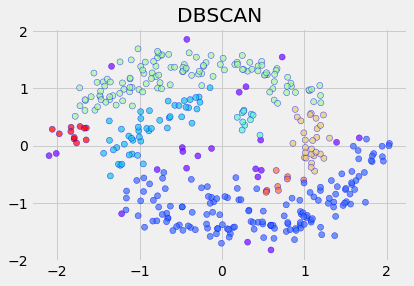

In [43]:
DBSCAN_GRID(X)

#### 1.3 HDBSCAN

HDBSCAN
Adjusted Rand Score:  0.28489860539368544


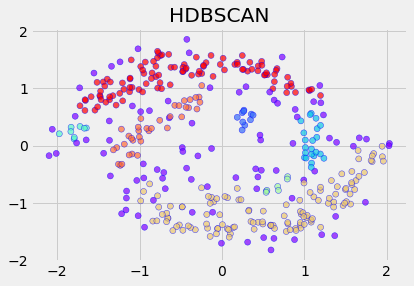

In [44]:
hdbscan(X,5)

#### 1.4 SPECTRAL

Adjusted Rand Score:  0.12032705349354188
Calinski - Harabasz score:  405.44761191864086
Spectral
Silhouette score: 0.4459651036187778
DB score:  0.8946605717082744
Elapsed time to cluster:  0.09903073310852051


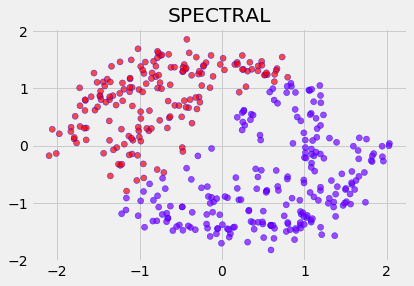

In [45]:
spectal(X)

#### 1.5 K-MEANS

K-means
Adjusted Rand Score:  0.1347322766509783


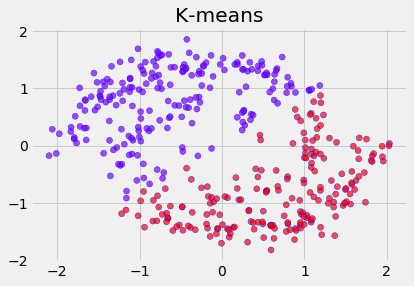

In [46]:
kmeans(X, 2)

#### 1.6 HIERARCHICAL

Hierarchical
Adjusted Rand Score:  0.18285385786816064
Calinski - Harabasz score:  406.60953431877
Silhouette score: 0.4537862290834896
DB score:  0.9071217886480175
Elapsed time to cluster:  0.012967109680175781


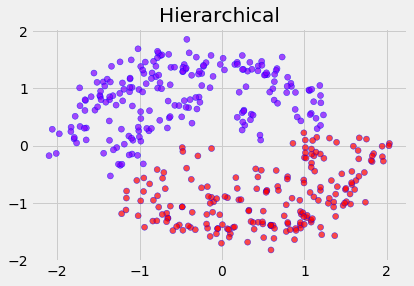

In [47]:
hier(X,2)

#### 1.7 MERGING AND COMPARING ALL PASSIBLE CASES THROUGH 100 RANDOM INTERATIONS

In [81]:
k_rand2=[]
h_rand2=[]
db_rand2=[]
hdb_rand2=[]
spec_rand2=[]
for i in range(100):
    X,labels_true=generate_spirals(200,1.5) 
    X = StandardScaler().fit_transform(X)
    hier_2(X,2)
    kmeans_2(X,2)
    DBSCAN_GRID2(X)
    hdbscan_2(X,5)
    spectral_2(X)

CREATE DATAFRAME WITH RAND SCORES FOR EACH ITERATION

In [82]:
columns=['Hierarchical Rand Score','K-means Rand Score','DBSCAN Rand Score',
         'HDBSCAN Rand Score','Spectral Rand Score']
scores= [h_rand2,k_rand2,db_rand2,hdb_rand2,spec_rand2]

In [83]:
a={'Hierarchical': h_rand2, 
   'K-means': k_rand2,
   'DBSCAN':db_rand2,
   'HDBSCAN ':hdb_rand2,
   'Spectral':spec_rand2}
df_high = pd.DataFrame(data=a)


In [84]:
df_high.loc['mean'] = df_high.mean() #mean of the scores for each clustering method
df_high.loc['Std'] = df_high.std() #standard deviation of the scores for each clustering method

In [85]:
df_high=df_high.round(3)
#aggiungere standard deviation

In [86]:
df_high.to_csv('2DSpirals_HIGHnoise.csv')
df_high.to_excel('2DSpirals_HIGHnoise.xls')

In [115]:
df_high.to_latex('2DSpirals_HIGHnoise.tex')

### COMPARING CLUSTERING METHODS WITH SMALL NOISE

In [24]:
X,labels_true=generate_spirals(200,0.5) 
X = StandardScaler().fit_transform(X)

DBSCAN
Adjusted Rand Score:  1.0
[0.30000000000000004, 1, 'euclidean', 1.0]


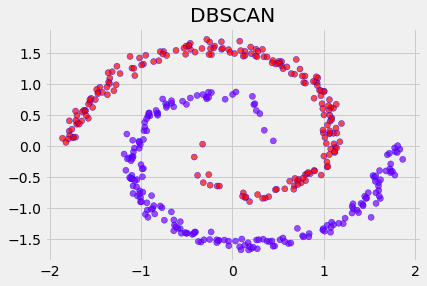

In [88]:
DBSCAN_GRID(X)

HDBSCAN
Adjusted Rand Score:  0.9511716880072069


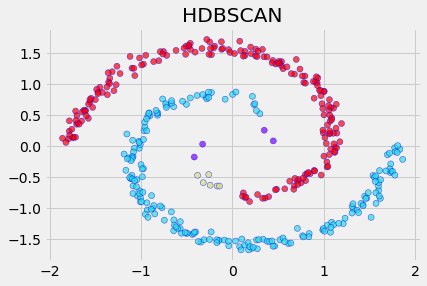

In [89]:
hdbscan(X,5)

Adjusted Rand Score:  0.6471743497370634
Calinski - Harabasz score:  172.10804604849008
Spectral
Silhouette score: 0.2852304774771255
DB score:  1.4231910191450108
Elapsed time to cluster:  0.12070918083190918


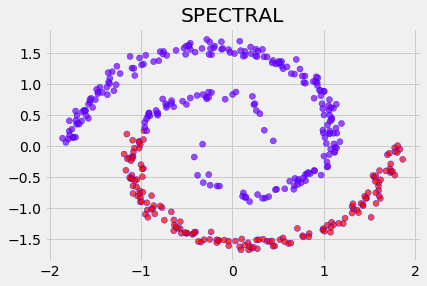

In [90]:
spectal(X)

Hierarchical
Adjusted Rand Score:  0.04827126033312081
Calinski - Harabasz score:  333.3068713209008
Silhouette score: 0.413820631165715
DB score:  1.00126575869855
Elapsed time to cluster:  0.01196742057800293


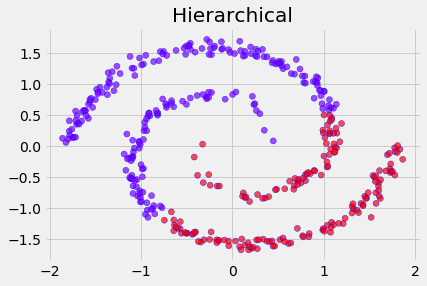

In [91]:
hier(X,2)

K-means
Adjusted Rand Score:  0.07330250795838526


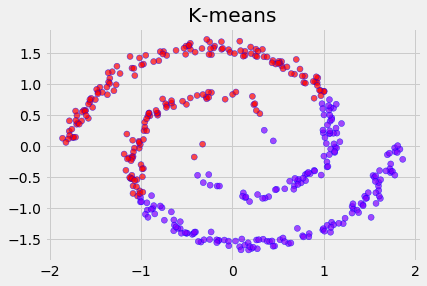

In [92]:
kmeans(X, 2)

COMPARISON

In [93]:
k_rand2=[]
h_rand2=[]
db_rand2=[]
hdb_rand2=[]
spec_rand2=[]
for i in range(100):
    X,labels_true=generate_spirals(200,0.5) 
    X = StandardScaler().fit_transform(X)
    hier_2(X,2)
    kmeans_2(X,2)
    DBSCAN_GRID2(X)
    hdbscan_2(X,5)
    spectral_2(X)

C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully

In [94]:
columns=['Hierarchical Rand Score','K-means Rand Score','DBSCAN Rand Score',
         'HDBSCAN Rand Score','Spectral Rand Score']
scores= [h_rand2,k_rand2,db_rand2,hdb_rand2,spec_rand2]

In [95]:
a={'Hierarchical': h_rand2, 
   'K-means': k_rand2,
   'DBSCAN':db_rand2,
   'HDBSCAN ':hdb_rand2,
   'Spectral':spec_rand2}
df_small = pd.DataFrame(data=a)

In [96]:
df_small.loc['mean'] = df_small.mean() #mean of the scores for each clustering method
df_small.loc['Std'] = df_small.std() #standard deviation of the scores for each clustering method

In [97]:
df_small=df_small.round(3)

In [98]:
df_small.to_csv('2DSpirals_SMALLnoise.csv')
df_small.to_excel('2DSpirals_SMALLnoise.xls')

In [114]:
df_small.to_latex('2DSpirals_SMALLnoise.tex')

### COMPARING CLUSTERING METHODS WITH MEDIUM NOISE

In [99]:
X,labels_true=generate_spirals(200,0.9) 
X = StandardScaler().fit_transform(X)

DBSCAN
Adjusted Rand Score:  0.9900748787469839
[0.30000000000000004, 8, 'euclidean', 0.9900748787469839]


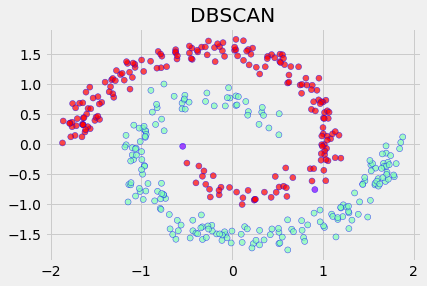

In [100]:
DBSCAN_GRID(X)

HDBSCAN
Adjusted Rand Score:  0.7976725179458255


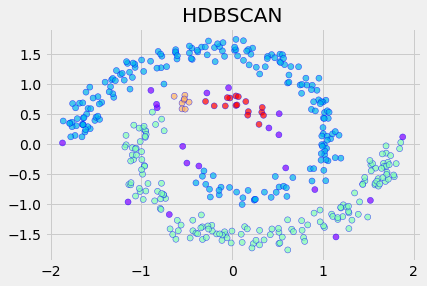

In [101]:
hdbscan(X,5)

Adjusted Rand Score:  0.4680240208957955
Calinski - Harabasz score:  226.20052569356938
Spectral
Silhouette score: 0.3270514793300464
DB score:  1.174065046308299
Elapsed time to cluster:  0.09275197982788086


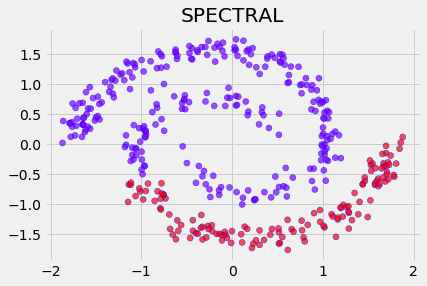

In [102]:
spectal(X)

K-means
Adjusted Rand Score:  0.10014562799434379


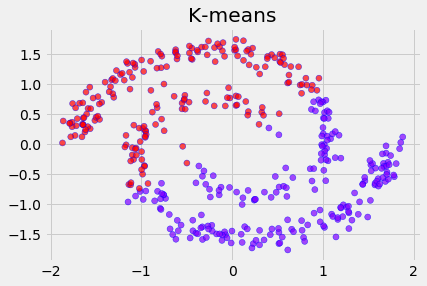

In [103]:
kmeans(X, 2)

Hierarchical
Adjusted Rand Score:  0.15791991445535633
Calinski - Harabasz score:  356.696026074967
Silhouette score: 0.4222668063339113
DB score:  0.9729259285063514
Elapsed time to cluster:  0.008977174758911133


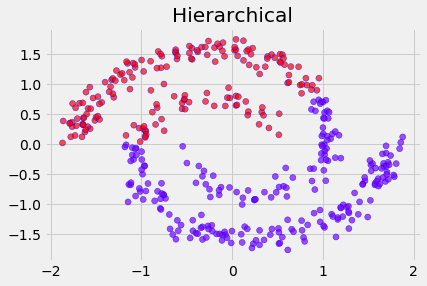

In [104]:
hier(X,2)

In [105]:
k_rand2=[]
h_rand2=[]
db_rand2=[]
hdb_rand2=[]
spec_rand2=[]
for i in range(100):
    X,labels_true=generate_spirals(200,0.9) 
    X = StandardScaler().fit_transform(X)
    hier_2(X,2)
    kmeans_2(X,2)
    DBSCAN_GRID2(X)
    hdbscan_2(X,5)
    spectral_2(X)
    

C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\croon\.conda\conda\envs\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully

In [106]:
columns=['Hierarchical Rand Score','K-means Rand Score','DBSCAN Rand Score',
         'HDBSCAN Rand Score','Spectral Rand Score']
scores= [h_rand2,k_rand2,db_rand2,hdb_rand2,spec_rand2]

In [107]:
a={'Hierarchical': h_rand2, 
   'K-means': k_rand2,
   'DBSCAN':db_rand2,
   'HDBSCAN ':hdb_rand2,
   'Spectral':spec_rand2}
df_medium = pd.DataFrame(data=a)

In [108]:
df_medium.loc['mean'] = df_medium.mean() #mean of the scores for each clustering method
df_medium.loc['Std'] = df_medium.std() #standard deviation of the scores for each clustering method

In [109]:
df_medium==df_medium.round(3)

,Hierarchical,K-means,DBSCAN,HDBSCAN,Spectral
0,False,False,True,False,True
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
97,False,False,False,False,False
98,False,False,False,False,False
99,False,False,True,False,False
mean,False,False,False,False,False


In [110]:
df_medium.to_csv('2DSpirals_MEDIUMnoise.csv')

In [111]:
df_medium.to_excel('2DSpirals_MEDIUMnoise.xls')


In [113]:
df_medium.to_latex('2DSpirals_MEDIUMnoise.tex')